In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

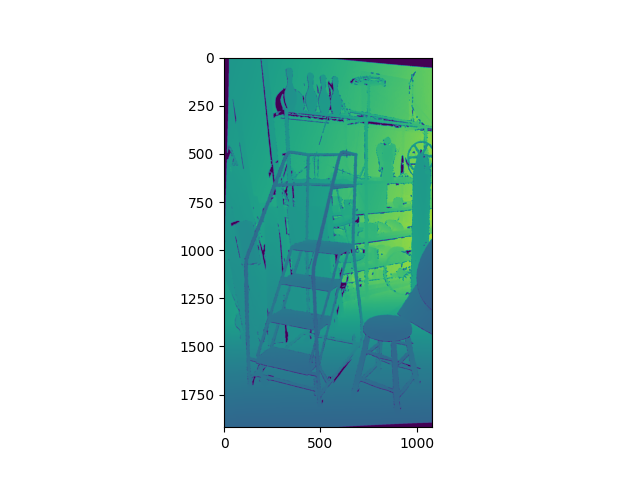

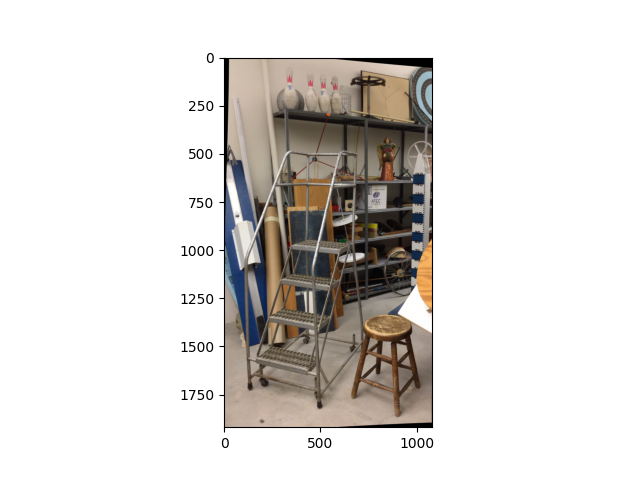

In [3]:
img_path = "c:/data/middlebury/all/data/ladder1/im0.png"
dispm_path = "c:/data/middlebury/all/data/ladder1/disp0.pfm"
f = 1733.68
cam = np.array([[f, 0, 819.72], [0, f, 957.55], [0, 0, 1]])
baseline=221.13
doffs=0

pfm = iio.imread(dispm_path,plugin="PFM-FI").astype(np.float32)


for y in range(pfm.shape[0]):
    for x in range(pfm.shape[1]):
        disp = pfm[y,x]
        if disp != 0:
            Z = baseline * f / (disp + doffs)
        else:
            Z = np.nan
        pfm[y,x] = Z

dm = np.flip(pfm,axis=0).copy()

im = iio.imread(img_path)
im = np.asarray(im)

plt.figure()
plt.imshow(dm)

plt.figure()
plt.imshow(im)


In [4]:
pts = []
invK = la.inv(cam)
for y in range(dm.shape[0]):
    for x in range(dm.shape[1]):
        dist = dm[y,x]
        pt = dist * (invK @ [x,y,1])
        pts.append(pt)

pts = np.array(pts)

In [5]:
#mesh['colors'] = my_rgb_array
#mesh.plot(scalars='colors', rgb=True, notebook=False)

mesh = pv.PolyData(pts)
mesh['colors'] = np.reshape(im,(-1,3))

#mesh.plot(scalars='colors',rgb=True, render_points_as_spheres=True,eye_dome_lighting=True,notebook=False)
mesh.plot(scalars='colors',rgb=True,notebook=False, eye_dome_lighting=True)

In [6]:
#from src.dmcpworkflow.annotate_points import annotate

#print(f"interactive matplotlib: {plt.isinteractive()}")
#mpl.use("QT5Agg")
#cps = annotate(im[:,:,0],dm) # exactly nonplanar 6 do seem best
#%matplotlib inline
#print(cps)

In [7]:
#cps[:,2:] = cps[:,:2]

In [8]:
#cps = np.array([[ 340.53626943,  498.71808761,  340.53626943,  498.71808761],
#       [ 441.31010699,  514.22175493,  441.31010699,  514.22175493],
#       [ 689.36878407,  506.46992127,  689.36878407,  506.46992127],
#       [ 619.60228114,  496.13414306,  619.60228114,  496.13414306],
#       [ 131.23676065, 1568.47113249,  131.23676065, 1568.47113249],
#       [ 492.98899805, 1661.4931364 ,  492.98899805, 1661.4931364 ],
#       [ 418.05460602, 1436.6899603 ,  418.05460602, 1436.6899603 ],
#       [ 715.20822959, 1488.36885136,  715.20822959, 1488.36885136]])

cps = np.array([[    702.29,    1677.00   ,  704.87  ,  1679.58],
 [    898.67  ,  1757.10   ,  898.67 ,   1754.52],
 [   1002.03,    1674.41 ,    994.27  ,  1664.08],
 [    968.43 ,   1540.05,     968.43  ,  1545.22],
 [    890.92 ,   1586.56,     885.75   , 1583.97],
 [    735.88 ,   1532.30   ,  738.46   , 1534.88],
 [    141.57 ,    863.05   ,  138.99  ,   870.81]])

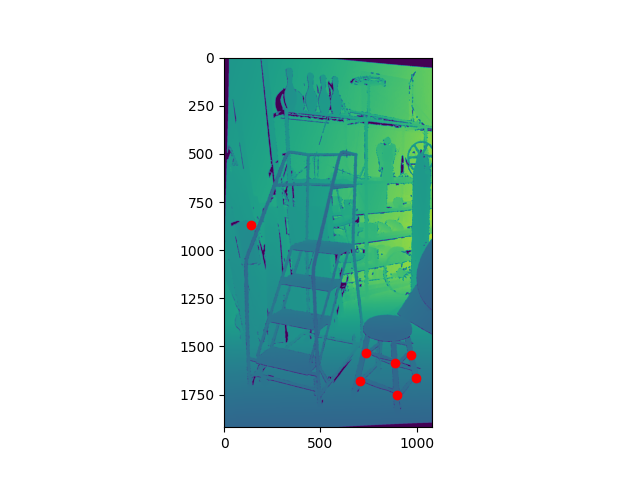

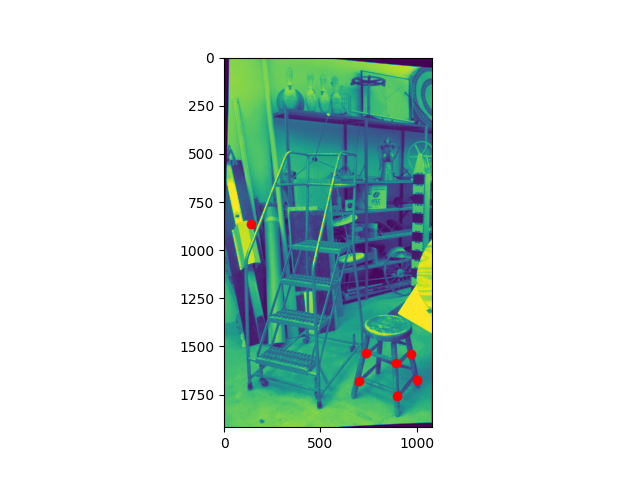

In [9]:
plt.figure()
plt.imshow(im[:,:,0])
plt.scatter(cps[:,0],cps[:,1],c="r")

plt.figure()
plt.imshow(dm,origin="upper")
plt.scatter(cps[:,2],cps[:,3],c="r")

plt.show()

In [10]:
from src.pycv.dmcp import dm_to_world
ext = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])
P_gt = cam @ ext

world_pts = dm_to_world(dm, cam, P_gt,cps[:,2:])
world_pts

array([[   -445.46,    2800.50,    6724.33],
       [    285.14,    2878.36,    6261.40],
       [    709.31,    2871.07,    7045.02],
       [    593.91,    2347.00,    6923.86],
       [    238.58,    2263.38,    6264.12],
       [   -311.06,    2209.99,    6636.44],
       [  -3597.33,    -458.38,    9161.65]], dtype=float32)

In [11]:
import pyvista as pv
cps_mesh = pv.PolyData(world_pts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True)
pl.add_mesh(cps_mesh, color="red", point_size=15, render_points_as_spheres=True)
pl.show()

In [12]:
from src.pycv.dmcp import dmcp
R  = np.array([ [ 0.6663311,  0.2944014,  0.6850771],
   [0.6567611,  0.2033320, -0.7261687],
  [-0.3530832,  0.9338008, -0.0578650 ]])
T = np.array([[100,100,-200]]).T
trans = np.hstack((R,T))
trans = np.vstack((trans,[0,0,0,1]))

P_im = P_gt @ la.inv(trans)

#P_im = P

A = dmcp(cam, P_im, cps[:,:2],world_pts)
print(f"A\n{A}")

estimated pose
[[     -0.98       0.07       0.19    1650.54]
 [      0.10      -0.64       0.76    6531.74]
 [      0.18       0.76       0.62   13785.62]]
A
[[     -0.50      -0.76       0.40    1858.00]
 [      0.40      -0.62      -0.68    6418.21]
 [      0.77      -0.18       0.61   13849.46]
 [      0.00       0.00       0.00       1.00]]


In [13]:
P_trans = P_im @ la.inv(A)

print("pose (mm)")
pos_est = la.null_space(P_trans) / la.null_space(P_trans)[-1]
pos_truth = la.null_space(P_gt) / la.null_space(P_gt)[-1]

pos_est = pos_est[:3].flatten()
pos_truth = pos_truth[:3].flatten()
pos_est 

pose (mm)


array([   1650.54,    6531.74,   13785.62])

dmcp works with arbitrary transformation 

In [14]:
sv_est = pv.Sphere(center=pos_est,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True)
pl.add_mesh(sv_gt, color="green")
pl.add_mesh(sv_est, color="blue")
pl.show()

reproject points

In [15]:
#P_trans @ world_pts
reprojected = P_trans @ np.hstack((world_pts,np.ones((world_pts.shape[0],1)))).T
reprojected = reprojected.T
repr0 = reprojected[:,0] / reprojected[:,-1]
repr1 = reprojected[:,1] / reprojected[:,-1]
repr = np.vstack((repr0,repr1)).T

plt.imshow(im[:,:,0])
plt.scatter(repr[:,0],repr[:,1], c="r")

they are on the same position thus the calibration is intrinsically valid

we need to add more constraints!

The idea now is to include the depth known from the depth map as an additional prior

In [16]:
import cv2 
from itertools import combinations

pt_idx = range(len(list(world_pts)))
combs = combinations(pt_idx,3)
possible_solutions = []
for comb in combs:
    comb = list(comb)
    world_batch = world_pts[comb,:]
    world_batch = np.ascontiguousarray(world_batch)
    image_batch = cps[comb,:2]
    image_batch = np.ascontiguousarray(image_batch).reshape((image_batch.shape[0],1,2))

    distCoeffs = np.array([[0, 0, 0, 0]]).astype("float32")
    retval, rvecs, tvecs = cv2.solveP3P(world_batch.astype("float32"), image_batch.astype("float32"), cam.astype("float32"), distCoeffs, flags=cv2.SOLVEPNP_AP3P)

    n_sol = len(rvecs)
    for i in range(len(rvecs)):
        possible_solutions.append((rvecs[i],tvecs[i]))


print(f"found {len(possible_solutions)} solutions")

possible_poses = []
for sol in possible_solutions:
    rvec, tvec = sol
    R,_ = cv2.Rodrigues(rvec)
    T = tvec
    camera_extrinsic_matrix = np.hstack((R,T))
    camera_extrinsic_matrix_hat = np.vstack((camera_extrinsic_matrix,[0,0,0,1]))
    camera_pose_matrix = la.inv(camera_extrinsic_matrix_hat)[:3,:]
    possible_poses.append(camera_pose_matrix)


print(f"example pose:\n{possible_poses[0]}")

found 108 solutions
example pose:
[[      1.00       0.02      -0.02      83.53]
 [     -0.03       1.00      -0.04     312.19]
 [      0.02       0.04       1.00     113.08]]


In [17]:
ts = []
for pose in possible_poses:
    T = pose[:,-1]
    ts.append(T)

ts = np.array(ts)

ts_mesh = pv.PolyData(ts)
pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True)
pl.add_mesh(ts_mesh, color="orange", point_size=10, render_points_as_spheres=True)
pl.show()

compare reprojection error for poses for all points (not only the 3 that the pose is optimized for)

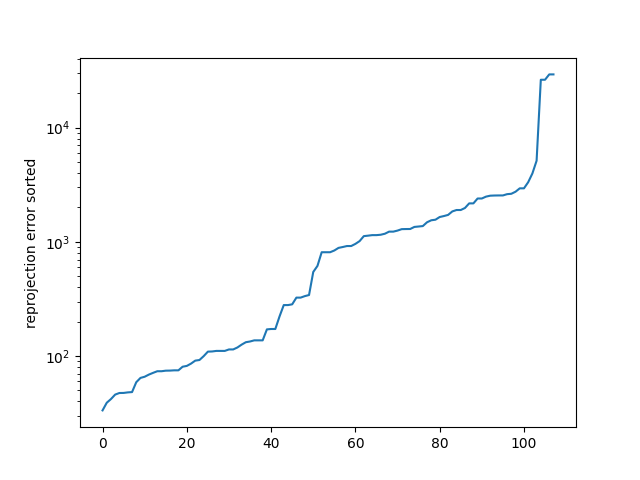

In [18]:
world_pts_hat = np.hstack((world_pts, np.ones((world_pts.shape[0],1)))).T
repr_errs = []
for i in range(len(possible_poses)):
    pose = possible_poses[i]
    pose_hat = np.vstack((pose,[0,0,0,1]))

    extr = la.inv(pose_hat)[:3,:]
    P = cam @ extr

    reprojected = P @ world_pts_hat
    reprojected = reprojected.T
    repr0 = reprojected[:,0] / reprojected[:,-1]
    repr1 = reprojected[:,1] / reprojected[:,-1]
    repr = np.vstack((repr0,repr1)).T
    repr_err = np.sum(abs(repr - cps[:,:2]))
    repr_errs.append(repr_err)

repr_errs = np.array(repr_errs)


ts_mesh["log_errors"] = np.log(repr_errs)

pl = pv.Plotter(off_screen=False,notebook=False)
pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True)
pl.add_mesh(ts_mesh, scalars="log_errors", point_size=10, render_points_as_spheres=True)
pl.show()

repr_errs_sorted = np.sort(repr_errs)

plt.figure()
plt.plot(np.arange(repr_errs_sorted.shape[0]),repr_errs_sorted[:])
plt.ylabel("reprojection error sorted")
plt.gca().set_yscale('log')
plt.show()



In [19]:
#from sklearn.cluster import AgglomerativeClustering
#
##X =np.log(repr_errs).reshape((-1,1))
#X = ts
#clustering = AgglomerativeClustering(n_clusters=None,linkage="ward",distance_threshold=np.sum(np.std(ts))).fit(X)
#
#
#ts_mesh["cluster"] = clustering.labels_
#
#pl = pv.Plotter(off_screen=False,notebook=False)
#pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True)
#pl.add_mesh(ts_mesh, scalars="cluster", point_size=10, render_points_as_spheres=True)
#pl.show()


In [20]:
min_err = np.inf
min_i = None
for i in range(repr_errs.shape[0]):
    err = repr_errs[i]
    if err < min_err:
        min_err = err
        min_i = i

print(f"best pose {min_i}, error {min_err}:\n{possible_poses[min_i]}")
best_pose = possible_poses[min_i]
best_pose
T_best = best_pose[:,-1]




best pose 75, error 33.40353329043268:
[[      1.00      -0.01      -0.03     205.05]
 [      0.01       1.00       0.01      13.84]
 [      0.03      -0.01       1.00     161.62]]


In [21]:
pos_truth = la.null_space(P_gt) / la.null_space(P_gt)[-1]
pos_truth = pos_truth[:3].flatten()

pl = pv.Plotter(off_screen=False,notebook=False)
sv_est = pv.Sphere(center=T_best,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius= 500)
pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True)
pl.add_mesh(ts_mesh, scalars="log_errors", point_size=5, render_points_as_spheres=True)
pl.add_mesh(sv_est, color="lightblue")
pl.add_mesh(sv_gt, color="lightgreen")
pl.show()

mean from best + std does not appear to work:

In [42]:
best2x_idx = []
stderr = np.std(repr_errs)
for i in range(repr_errs.shape[0]):
    err = repr_errs[i]
    if err >= min_err + stderr:
        best2x_idx.append(i)

best2x_idx = np.array(best2x_idx)

tst = ts[best2x_idx].mean(axis=0)
print(ts[best2x_idx])
print(tst)

pl = pv.Plotter(off_screen=False,notebook=False)
sv_est = pv.Sphere(center=T_best,radius=500)
sv_gt = pv.Sphere(center=pos_truth,radius=500)
sv_tst = pv.Sphere(center=tst,radius=500)
pl.add_mesh(mesh, scalars="colors",rgb=True, render_points_as_spheres=True)
pl.add_mesh(ts_mesh, scalars="log_errors", point_size=5, render_points_as_spheres=True)
pl.add_mesh(sv_est, color="lightblue")
pl.add_mesh(sv_gt, color="lightgreen")
pl.add_mesh(sv_tst, color="black")
pl.show()

[[     70.44     902.78    6296.54]
 [     70.44     902.78    6296.54]
 [    159.60    1232.75    9950.89]
 [    159.60    1232.75    9950.89]]
[    115.02    1067.77    8123.72]
